

## Feature Engineering

We will add some more features.

In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.special import inv_boxcox, boxcox1p

# supress unnecessary warnings for readability and cleaner presentation
warnings.filterwarnings('ignore')

%matplotlib inline
plt.style.use('bmh')

In [2]:
# helper function which performs all steps of data processing which we applied during 
# Data cleaning and preprocessing
def read_clean_data():
    
    # reading data
    df_train = pd.read_csv('use_case_data.csv')
    df_score = pd.read_csv('score_data.csv')

    df_train['data_type'] = 'train'
    df_score['data_type'] = 'score'
    
    # removing negative market shares
    temp = df_train[df_train['Market_Share'] >= 0]
    
    # applying boxcox
    market_share = stats.boxcox(temp['Market_Share'].values + 1e-30, lmbda=0.25)
    
    # combining train and score
    data = pd.concat([temp.drop(columns='Market_Share'), df_score],ignore_index=True)
    
    # adding response variable
    data['Market_Share'] = np.nan
    mask = data['data_type'] == 'train'
    data.loc[mask, 'Market_Share'] = market_share
    data.drop(columns='data_type', inplace=True)
    
    # changing dtype to category
    data['ITEMSCODE'] = data['ITEMSCODE'].astype('category')

    # spliting to year and month, adding to not_useful_features list
    data['LAUNCH_YEAR'], data['LAUNCH_MONTH'] = data['NPLLAUNCHDATE'].map(str).apply(lambda x: [x[:4], x[4:]]).str   
    
    # removing not useful features
    not_useful = ['BRMID', 'LATESTPERIODINDEX', 'NPLLAUNCHDATE', 'ISREPLACEMENT', 'BRM', 'MARKETEDBRAND',
                  'BRANDSUBFAMILY', 'NPLLAUNCHYEAR', 'RTYPE', 'ITEMSHAPE']
    
    data.drop(columns=not_useful, inplace=True)
    
    # filling missing values
    data['SPECIALFLAVOR'].fillna('NOSPECIALFLAVOR', inplace=True)
    data['TIPCOLOR'].fillna('NOTIPCOLOR', inplace=True)
    
    # transform categorical features into the appropriate type
    for c in data.columns:
        col_type = data[c].dtype
        if col_type == 'object' or col_type.name == 'category':
            data[c] = data[c].astype('category')
            
    # transforming with boxcox1p for reducing skew
    data[['LEN', 'NCON', 'RETAILPACKPRICE']] = boxcox1p(data[['LEN', 'NCON', 'RETAILPACKPRICE']], -0.25)

    print('all data shape: {}'.format(data.shape))
    return data

We will add some more features by aggregating some categorical features by numeric ones.

For example, we will calculate **mean, median, std, skew** of **RETAILPACKPRICE** for each **REGION**. 

In [3]:
def aggregate(data, f_1, f_2):
    """Aggregates f_1 by f_2"""

    mean_ = '{}_{}_mean'.format(f_1, f_2)
    median_ = '{}_{}_median'.format(f_1, f_2)
    std_ = '{}_{}_std'.format(f_1, f_2)
    skew_ = '{}_{}_skew'.format(f_1, f_2)
    
    # aggregation of f_1 by f_2
    temp = data.groupby(f_1)[f_2].aggregate({
        mean_: np.mean,
        std_: np.std,
        median_: np.median,
        skew_: stats.skew
    }).reset_index()
    
    # filling nans with 0
    for x in (mean_, std_, median_, skew_):
        temp[x].fillna(0, inplace=True)
        
    data = data.merge(temp)
    
    # adding relative (for example product RETAILPACKPRICE / REGION mean RETAILPACKPRICE)
    relative_mean_ = '{}_{}_relative_mean'.format(f_1, f_2)
    relative_median_ = '{}_{}_relative_median'.format(f_1, f_2)
    
    def relative(row, f):
        f_value, f_2_value = row[f], row[f_2]
        if f_value == 0 and f_2_value == 0:
            return 1.
        elif f_value == 0 and f_2_value != 0:
            return -99999
        else:
            return f_2_value / f_value
        
#     data[relative_mean_] = data.apply(lambda row: relative(row, mean_), axis=1)
    data[relative_median_] = data.apply(lambda row: relative(row, median_), axis=1)
    return data

In [4]:
def feature_engineering(data, to_drop=None, to_aggregate=None, to_dummy=False, cardinality_ratio=1., ):
    """
    Recives cleaned and preprocessed data, add features, high cardinality features and makes one-hot encoding.
    """
    temp = data.copy()

    # removing high cardinality categorical features
    if cardinality_ratio < 1.:
        n = len(temp)
        high_cardinalty_features = []
        for c in temp.columns:
            if temp[c].dtype.name == 'category' and len(temp[c].unique()) / n > cardinality_ratio:
                high_cardinalty_features.append(c)
        print('Removing {} features, which have high cardinality.'.format(high_cardinalty_features))
        temp.drop(columns=high_cardinalty_features, inplace=True)
    
    # aggergation
    numeric_fs = [c for c in temp.columns if temp[c].dtype.name != 'category' and c != 'Market_Share']
    for f_1 in to_aggregate:
        for f_2 in numeric_fs:
            temp = aggregate(temp, f_1, f_2)
    
    # adding also **2, **3 and **0.5 for LEN and RETAILPACKPRICE
    for x in ['LEN', 'RETAILPACKPRICE']:
        temp['{}_**2'.format(x)] = temp[x] ** 2
        temp['{}_**3'.format(x)] = temp[x] ** 2
        temp['{}_**0.5'.format(x)] = np.sqrt(np.abs(temp[x]))        
    print('all data shape after features addition: {}'.format(temp.shape))
    
    # dropping some features
    if to_drop:
        temp.drop(columns=to_drop, inplace=True)
        print('all data shape after features deletion: {}'.format(temp.shape))
    

    # one-hot encoding for categorical features
    if to_dummy:
        temp = pd.get_dummies(temp)
        print('all data shape after one-hot-encoding: {}'.format(temp.shape))

    # splitting into train and score
    mask = temp['Market_Share'].notnull()
    training_data, score_data = temp[mask], temp[np.invert(mask)]
    score_data.drop(columns='Market_Share', inplace=True)
    print('training data shape: {}, score data shape: {}'.format(
        training_data.shape, score_data.shape))
    return training_data, score_data

## Evaluation metrics

In [5]:
import itertools
from sklearn.metrics import mean_squared_error, explained_variance_score, r2_score
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix
from sklearn.base import clone
from sklearn.model_selection import KFold, train_test_split
from tabulate import tabulate

In [6]:
def plot_confusion_matrix(matrix, classes, cmap=plt.cm.Reds):
    """This function plots the normalized confusion matrix."""
    matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

    plt.imshow(matrix, interpolation='nearest', cmap=cmap)
    plt.title('Normalized Confusion matrix', fontsize=17)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=15)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=12)
    plt.yticks(tick_marks, classes, fontsize=12)

    fmt = '.2f'
    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]),range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], fmt),
                 horizontalalignment="center", fontsize=17,
                 color="blue" if matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
    plt.show()
    

def plot_model_performance(y_true, y_pred, matrix):
    """
    This function plots:
        - predicted values vs actual values
        - confusion matrix
        - roc curve
    """
    print()
    
    # plotting predicted values vs actual ones
    plt.figure(figsize=(10, 10))
    plt.scatter(y_true, y_pred)
    plt.title('Actual values vs Predicted values.')
    plt.ylabel('Predicted', fontsize=12)
    plt.xlabel('Actual', fontsize=12)
    plt.show()
              
    print()
    
    # plotting confusion matrix
    plot_confusion_matrix(matrix, ['Failure', 'Success'])
    
    print()
    threshold = 0.007
    threshold_transformed = stats.boxcox(threshold, 0.25)
    binary_target = y_true > threshold_transformed
    
    fpr, tpr, _ = roc_curve(binary_target, y_pred)
    auc_score = auc(fpr, tpr)
    
    plt.figure(figsize=(10, 10))
    plt.plot(fpr, tpr, lw=3, alpha=0.3, label='ROC (AUC = %0.2f)' % (auc_score))
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.title('ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()

In [7]:
def scorer(y_true, y_pred):
    """Calculates differnt merics for evaluating our models."""

    threshold = 0.007
    threshold_transformed = stats.boxcox(threshold, 0.25)

    binary_prediction = y_pred > threshold_transformed
    binary_target = y_true > threshold_transformed

    """Regression metrics"""
    
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    explained_variance = explained_variance_score(y_true, y_pred)
    r_2 = r2_score(y_true, y_pred)

    """Classification metrics"""

    # The probability that the model ranks a random
    # positive example more highly than a random negative example.
    auc = roc_auc_score(binary_target, y_pred)

    conf_matrix = confusion_matrix(binary_target, binary_prediction)
    # true positives (TP): We predicted Y and they do have the disease.
    # true negatives (TN): We predicted N, and they don't have the disease.
    # false positives (FP): We predicted Y, but they don't have the disease.
    # false negatives (FN): We predicted N, but they do have the disease.
    tn, fp, fn, tp = conf_matrix.ravel()

    # correct labels
    total = tn + fp + fn + tp
    actual_yes = fn + tp
    actual_no = total - actual_yes

    # Overall, how often is the classifier correct?
    accuracy = (tp + tn) / total

    # Overall, how often is it wrong?
    misclassification_rate = (fp + fn) / total

    # When it is actually Y, how often does it predict Y?
    # Probability that a test result will be positive when the disease is present.
    # Recall
    tp_rate = tp / actual_yes

    # When it is actually N, how often does it predict N?
    # Probability that a test result will be negative when the disease is not present.
    specificity = tn / actual_no

    # When it is actually N, how often does it predict Y?
    # 1 - specificity
    fp_rate = fp / actual_no

    # When it predicts Y, how often is it correct?
    # Probability that the disease is present when the test is positive.
    # Positive Predictive Value or precision
    pp_value = tp / (fp + tp)

    # When it predicts N, how often is it correct?
    # Probability that the disease is not present when the test is negative.
    # Negative Predictive Value
    np_value = tn / (tn + fn)

    # The weighted average of recall and precision.
    f_score = 2 * tp_rate * pp_value / (tp_rate + pp_value)

    return {
        'rmse': rmse,
        'explained_variance': explained_variance,
        'r_2': r_2,
        'confusion_matrix': conf_matrix,
        'accuracy': accuracy,
        'tpr': tp_rate,
        'specificity': specificity,
        'fpr': fp_rate,
        'ppv': pp_value,
        'npv': np_value,
        'f_score': f_score,
        'auc': auc,
    }



**5 fold CV strategy: we will validate our models and tune hyperparameters by 5 fold CV**

In [8]:
def cv_mean_score(fold_scores):
    """Calculates model mean score based on list of each folds scores."""
    if not fold_scores:
        return
    keys = list(fold_scores[0].keys())
    data = {k: [x[k] for x in fold_scores] for k in keys if k != 'confusion_matrix'}
    return {k: (np.mean(v), np.std(v)) for k, v in data.items()}   

def cv(model, train_data, train_y, n_folds=5, verbose=True):
    """Helper function for doing cross validation and collecting metrics."""

    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

    training_metrics, validatin_metrics = [], []
    for i, (train_ind, valid_ind) in enumerate(kf.split(train_data)):
        model_ = clone(model)
        model_.fit(train_data.iloc[train_ind], train_y.iloc[train_ind])

        train_y_pred = model_.predict(train_data.iloc[train_ind])
        t_metrics = scorer(train_y.iloc[train_ind].values, train_y_pred)

        valid_y_pred = model_.predict(train_data.iloc[valid_ind])
        v_metrics = scorer(train_y.iloc[valid_ind].values, valid_y_pred)
        tabular_metrics = [[k, t_metrics[k], v_metrics[k]]
                           for k in t_metrics.keys()
                           if k != 'confusion_matrix']
        
        if verbose:
            print('\nfold: {}\n'.format(i + 1))
            print(tabulate(tabular_metrics,
                           headers=['metric_name', 'training_set', 'validation_set'],
                           tablefmt="fancy_grid",
                           floatfmt=",.3f"))

        training_metrics.append(t_metrics)
        validatin_metrics.append(v_metrics)

    mean_t_score = cv_mean_score(training_metrics)
    mean_v_score = cv_mean_score(validatin_metrics)

    tabular_mean_metrics = [
        [k, mean_t_score[k][0], mean_t_score[k][1], mean_v_score[k][0], mean_v_score[k][1]]
        for k in mean_t_score.keys()]

    tabular_mean_metrics = tabulate(
        tabular_mean_metrics,
        headers=['metric_name', 'train: mean', 'train: std', 'valid: mean', 'valid: std'],
        tablefmt="fancy_grid",
        floatfmt=",.3f")
    return tabular_mean_metrics, mean_t_score, mean_v_score

In [9]:
def evaluate_model(model, data, y, training=True):
    """Evaluates model on train or test data."""
    
    if training:
        # fitting model before prediction
        model.fit(data, y)
    
    # predicition
    y_pred = model.predict(data)
    
    metrics = scorer(y, y_pred)
    plot_model_performance(y, y_pred, metrics.pop('confusion_matrix'))
    for k, v in metrics.items():
        print('{}: {:.3f}'.format(k, v))
    
    return model, metrics



## Modeling

### Data preparation

**Import librairies**

In [10]:
from sklearn.linear_model import ElasticNet, Lasso
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler

import lightgbm as lgb

**Preparing data: data clening, preprocessing and feature engineering, one-hot-encoding**

In [11]:
df = read_clean_data()

# split into numeric and categorical
numeric_fs = [c for c in df.columns if df[c].dtype.name != 'category' and c != 'Market_Share']
categoircal_fs = list(set(df.columns) - set(numeric_fs) - {'Market_Share'})

all data shape: (1721, 32)


In [12]:
# categorical features, which will be aggregated
to_aggregate = [
    'TCLASS',
    'REGION',
    'LOCALCLASS',
    'BLDIMAGE', 
    'MARKET',
    'MINDICATOR', 
    'THICATEGORY', 
    'PCKT',
]

# categorical features, which will be dropped
to_drop = [
    'BRANDSUBFAMILYGROUPING', 
    'BRANDSUBFAMILYLINE',
    'BRANDSUBFAMILYGROUP', 
    'BRANDONMARKET',
    'BRANDDIFFERENTIATOR',
]

training_df, score_df = feature_engineering(df, 
                                            to_drop=to_drop, 
                                            to_aggregate=to_aggregate,
                                            to_dummy=True, 
                                            cardinality_ratio=1.)

numeric_fs = [c for c in training_df.columns if training_df[c].dtype.name != 'category' and c != 'Market_Share']
categoircal_fs = list(set(training_df.columns) - set(numeric_fs) - {'Market_Share'})

all data shape after features addition: (1721, 198)
all data shape after features deletion: (1721, 193)
all data shape after one-hot-encoding: (1721, 517)
training data shape: (1692, 517), score data shape: (29, 516)


**Train - Test split: we will keep 15% of data for final testing**

In [13]:
train, test = train_test_split(training_df, test_size=0.15, shuffle=True)
print(train.shape, test.shape)

(1438, 517) (254, 517)


In [14]:
# separating response variable
y_train, X_train = train['Market_Share'], train.drop(columns='Market_Share')
y_test, X_test = test['Market_Share'], test.drop(columns='Market_Share')

### Cross Validation

**Base models and their scores on 5 fold CV:**

As models we have selected 4 models: Lasso regression, Elastic Net, ExtraTress regression and Gradient tree boosting. First two models are more linear than other two. First 2 models are modifications of linear regession with additional constraints on regression coefficients. The last 2 models are more no-linear models based on decision trees.

In [15]:
all_models, all_models_scores = {}, {}

* **LASSO Regression (Sklearn):**

https://en.wikipedia.org/wiki/Lasso_(statistics)

https://scikit-learn.org/stable/modules/linear_model.html#lasso

This model may be very sensitive to outliers. So we need to made it more robust on them. For that we use the sklearn's **Robustscaler()** method on pipeline.

In [16]:
model_lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.0003, max_iter=1e3, tol=1e-5, random_state=1))
score, _, _ = cv(model_lasso, X_train, y_train)

all_models['lasso'] = model_lasso
all_models_scores['lasso'] = score
print('\nLasso score:\n')
print(score)


fold: 1

╒════════════════════╤════════════════╤══════════════════╕
│ metric_name        │   training_set │   validation_set │
╞════════════════════╪════════════════╪══════════════════╡
│ rmse               │          0.212 │            0.267 │
├────────────────────┼────────────────┼──────────────────┤
│ explained_variance │          0.533 │            0.313 │
├────────────────────┼────────────────┼──────────────────┤
│ r_2                │          0.533 │            0.313 │
├────────────────────┼────────────────┼──────────────────┤
│ accuracy           │          0.851 │            0.854 │
├────────────────────┼────────────────┼──────────────────┤
│ tpr                │          0.362 │            0.347 │
├────────────────────┼────────────────┼──────────────────┤
│ specificity        │          0.968 │            0.958 │
├────────────────────┼────────────────┼──────────────────┤
│ fpr                │          0.032 │            0.042 │
├────────────────────┼────────────────┼───────

* **Elastic Net Regression (Sklearn):**

https://en.wikipedia.org/wiki/Elastic_net_regularization

https://scikit-learn.org/stable/modules/linear_model.html#elastic-net

again made robust to outliers

In [17]:
model_enet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=0.8, random_state=3))
score, _, _ = cv(model_enet, X_train, y_train)

all_models['elastic_net'] = model_enet
all_models_scores['elastic_net'] = score
print('\nElastic Net:\n')
print(score)


fold: 1

╒════════════════════╤════════════════╤══════════════════╕
│ metric_name        │   training_set │   validation_set │
╞════════════════════╪════════════════╪══════════════════╡
│ rmse               │          0.218 │            0.268 │
├────────────────────┼────────────────┼──────────────────┤
│ explained_variance │          0.506 │            0.308 │
├────────────────────┼────────────────┼──────────────────┤
│ r_2                │          0.506 │            0.307 │
├────────────────────┼────────────────┼──────────────────┤
│ accuracy           │          0.851 │            0.851 │
├────────────────────┼────────────────┼──────────────────┤
│ tpr                │          0.326 │            0.286 │
├────────────────────┼────────────────┼──────────────────┤
│ specificity        │          0.976 │            0.967 │
├────────────────────┼────────────────┼──────────────────┤
│ fpr                │          0.024 │            0.033 │
├────────────────────┼────────────────┼───────

* **Extra Trees Regressor (Sklearn):**

https://www.quora.com/What-is-the-extra-trees-algorithm-in-machine-learning

https://scikit-learn.org/stable/modules/ensemble.html#forest

https://stats.stackexchange.com/questions/44382/mathematics-behind-classification-and-regression-trees


In [18]:
model_extratree = ExtraTreesRegressor(
    n_estimators=200,
    max_depth=50,
    min_samples_split=2, 
    min_samples_leaf=2,
    min_weight_fraction_leaf=0.0002,
    max_leaf_nodes=None,
    max_features='auto',
    min_impurity_decrease=0.00,
    n_jobs=2
)

score, _, _ = cv(model_extratree, X_train, y_train)

all_models['extra_tree'] = model_extratree
all_models_scores['extra_tree'] = score
print('\nExtraTree:\n')
print(score)


fold: 1

╒════════════════════╤════════════════╤══════════════════╕
│ metric_name        │   training_set │   validation_set │
╞════════════════════╪════════════════╪══════════════════╡
│ rmse               │          0.064 │            0.249 │
├────────────────────┼────────────────┼──────────────────┤
│ explained_variance │          0.957 │            0.401 │
├────────────────────┼────────────────┼──────────────────┤
│ r_2                │          0.957 │            0.399 │
├────────────────────┼────────────────┼──────────────────┤
│ accuracy           │          0.978 │            0.858 │
├────────────────────┼────────────────┼──────────────────┤
│ tpr                │          0.928 │            0.347 │
├────────────────────┼────────────────┼──────────────────┤
│ specificity        │          0.990 │            0.962 │
├────────────────────┼────────────────┼──────────────────┤
│ fpr                │          0.010 │            0.038 │
├────────────────────┼────────────────┼───────

* **GradientTreeBossting (LightGBM) :**

https://en.wikipedia.org/wiki/Gradient_boosting

https://medium.com/mlreview/gradient-boosting-from-scratch-1e317ae4587d

https://lightgbm.readthedocs.io/en/latest/


In [19]:
model_lgb = lgb.LGBMRegressor(
    boosting_type='gbdt',
    objective='rmse',
    n_estimators=5000,
    learning_rate=0.03,
    
    max_depth=6,             # Specify the max depth to which tree will grow. 
    num_leaves=24,             # Number of leaves in one tree

    min_child_weight=11,     # minimal sum hessian in one leaf
    min_data_in_leaf=20,       # Min number of data in one leaf.
    
    subsample=0.75,            # Specifies the fraction of data to be used for each iteration
    subsample_freq=5,
    bagging_seed=9,
    
    colsample_bytree=0.45,  # Specifies the fraction of features to be taken for each iteration
    feature_fraction_seed=7,
    
    min_gain_to_split=0.002,    # Min gain to perform splitting
    reg_alpha=0.00,
    reg_lambda=0.,
    n_jobs=2,
)

score, _, _ = cv(model_lgb, X_train, y_train)

all_models['gradient_tree_boosting'] = model_lgb
all_models_scores['gradient_tree_boosting'] = score
print('\nLGBM:\n')
print(score)


fold: 1

╒════════════════════╤════════════════╤══════════════════╕
│ metric_name        │   training_set │   validation_set │
╞════════════════════╪════════════════╪══════════════════╡
│ rmse               │          0.042 │            0.247 │
├────────────────────┼────────────────┼──────────────────┤
│ explained_variance │          0.982 │            0.409 │
├────────────────────┼────────────────┼──────────────────┤
│ r_2                │          0.982 │            0.408 │
├────────────────────┼────────────────┼──────────────────┤
│ accuracy           │          0.979 │            0.844 │
├────────────────────┼────────────────┼──────────────────┤
│ tpr                │          0.914 │            0.408 │
├────────────────────┼────────────────┼──────────────────┤
│ specificity        │          0.995 │            0.933 │
├────────────────────┼────────────────┼──────────────────┤
│ fpr                │          0.005 │            0.067 │
├────────────────────┼────────────────┼───────

**Mean CV scores for each model:**

In [20]:
for k, v in all_models_scores.items():
    print('\n model: {} mean CV score'.format(k))
    print(v)
    print()


 model: lasso mean CV score
╒════════════════════╤═══════════════╤══════════════╤═══════════════╤══════════════╕
│ metric_name        │   train: mean │   train: std │   valid: mean │   valid: std │
╞════════════════════╪═══════════════╪══════════════╪═══════════════╪══════════════╡
│ rmse               │         0.209 │        0.003 │         0.271 │        0.011 │
├────────────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│ explained_variance │         0.551 │        0.016 │         0.242 │        0.088 │
├────────────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│ r_2                │         0.551 │        0.016 │         0.239 │        0.092 │
├────────────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│ accuracy           │         0.862 │        0.006 │         0.830 │        0.014 │
├────────────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│ tpr                │         0.393

Some insights from scores: 

* As excpected **Lasso** and **ElasticNet** performance are almost similar. Besides this their performance is also low compared to DecisionTree models, which is also expected as we investigated that our data mostly non linear.

* If we compare **GradientTreeBoosting** and **ExtraTrees** then we can notice that their performances are comparable: mean validation RMSE is almost equal and AUC is almost equal. We see some difference for tpr (true positive ratio - When it is actually Y, how often does it predict Y?) and fpr (false positive ratio - When it is actually N, how often does it predict Y?) metrics for given 0.7% threshold. As we can see both are bigger for GradientTreeBoosting based model **(tpr: 0.429 vs 0.342, fpr: 0.069  vs 0.051)**. So what does it mean? We can assume that GradientTreeBoosting based model learned more from data than ExtraTrees (as it is more complex model than ExtraTrees), so it can differentiate more succesful launches, but together with that the false positive ratio is more by 1.8%, which is not good from bussiness prospective. So GradientTreeBoosting based models pays fpr increase cost (by 1.8%) for having higher ptr by 8.7%. 


**Training scores on full training data for each model:**

In this section using all training data we fit model on it and afterwards using the same training data make predictions. We compare that predictions with actual data. So if the model fitted properly, it should show very high performance metrics (AUC > 0.95, RMSE < 0.06).


 model: lasso train score



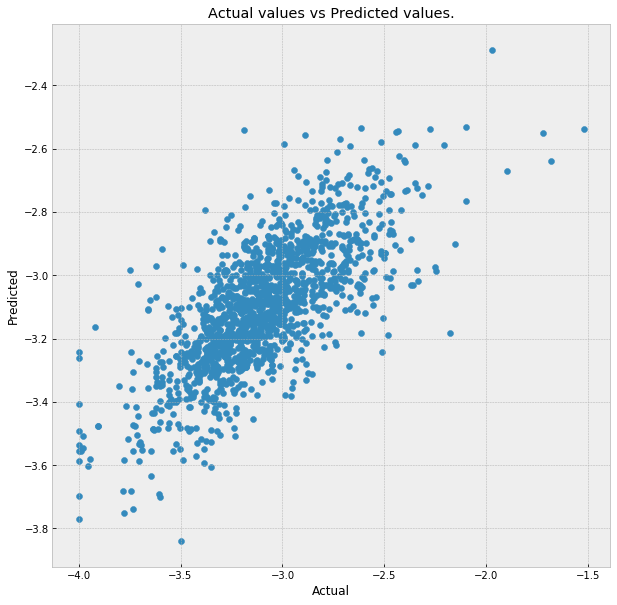

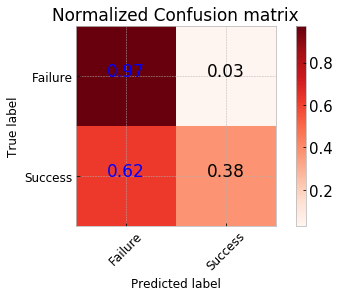

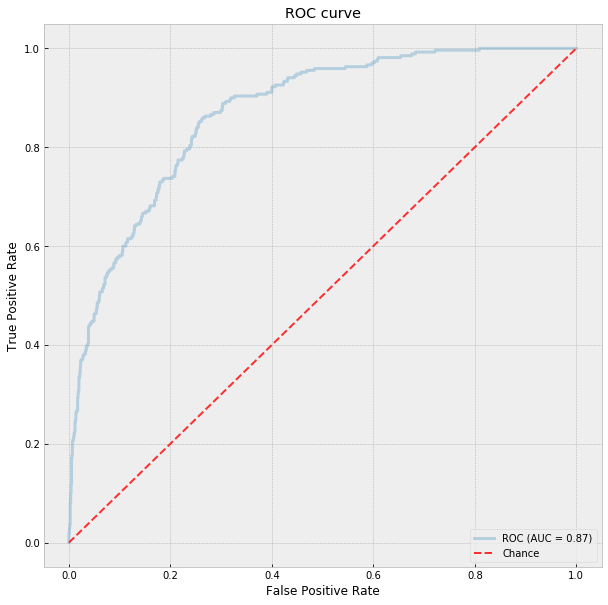

rmse: 0.217
explained_variance: 0.518
r_2: 0.518
accuracy: 0.860
tpr: 0.378
specificity: 0.971
fpr: 0.029
ppv: 0.750
npv: 0.871
f_score: 0.502
auc: 0.870


 model: elastic_net train score



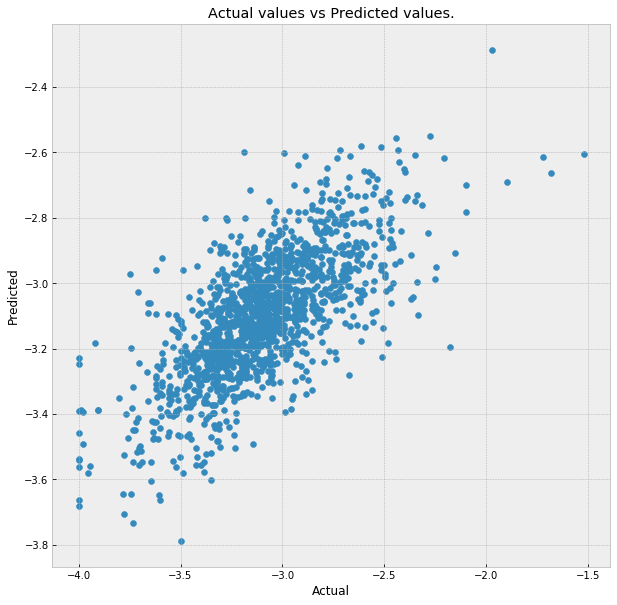

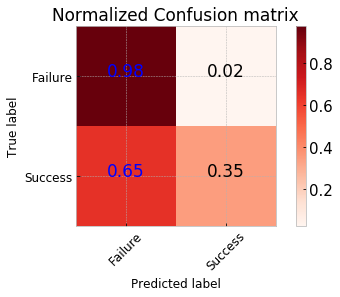

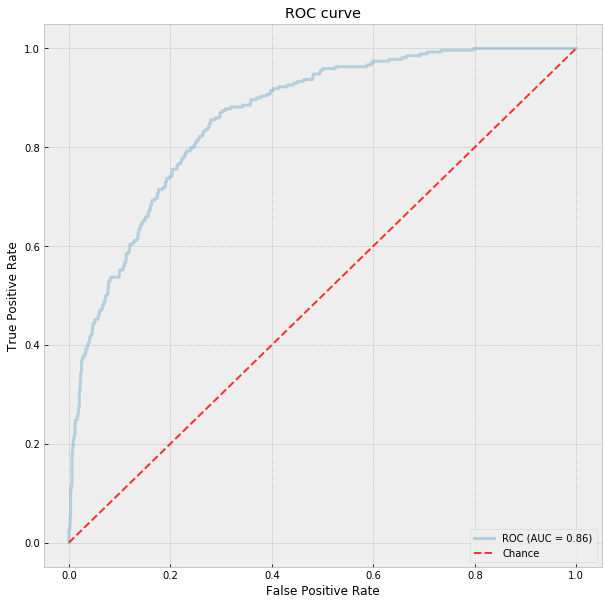

rmse: 0.223
explained_variance: 0.489
r_2: 0.489
accuracy: 0.857
tpr: 0.348
specificity: 0.975
fpr: 0.025
ppv: 0.764
npv: 0.866
f_score: 0.478
auc: 0.862


 model: extra_tree train score



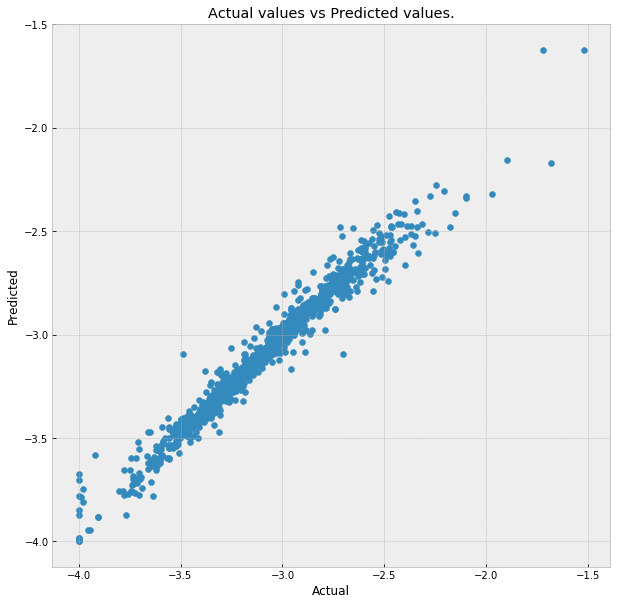

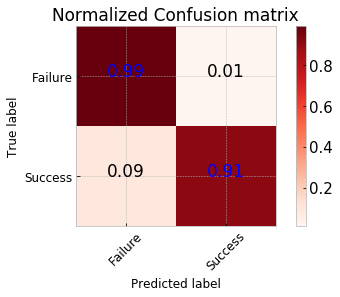

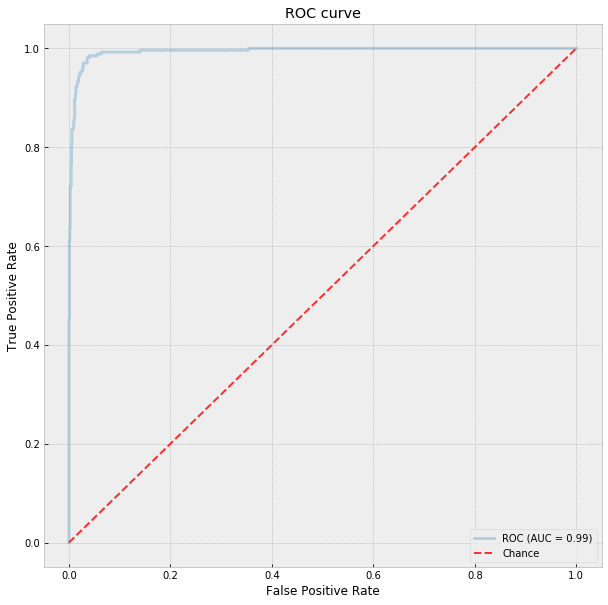

rmse: 0.060
explained_variance: 0.963
r_2: 0.963
accuracy: 0.972
tpr: 0.907
specificity: 0.987
fpr: 0.013
ppv: 0.942
npv: 0.979
f_score: 0.925
auc: 0.994


 model: gradient_tree_boosting train score



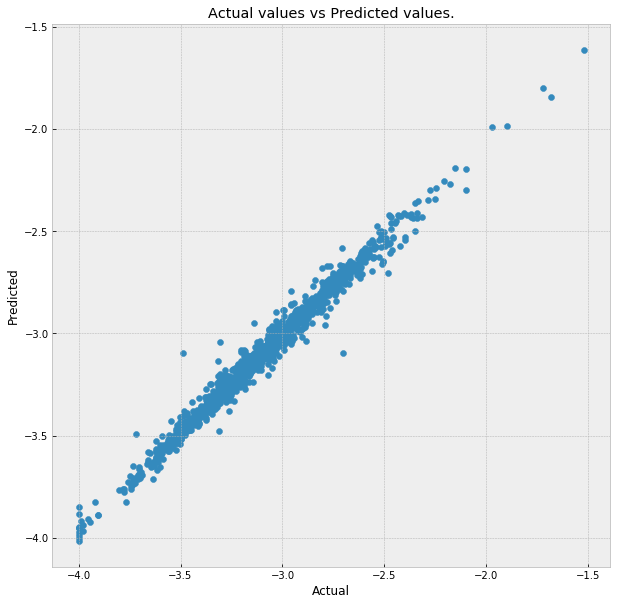

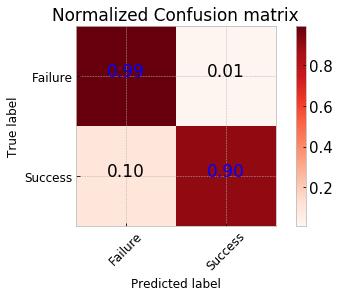

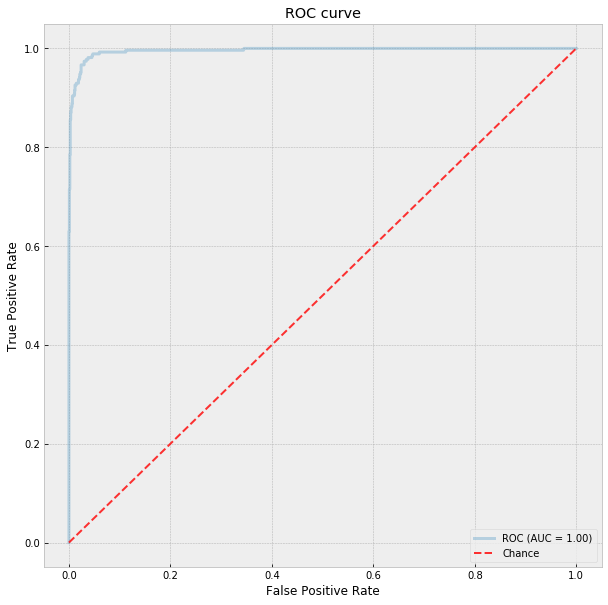

rmse: 0.045
explained_variance: 0.980
r_2: 0.980
accuracy: 0.974
tpr: 0.904
specificity: 0.991
fpr: 0.009
ppv: 0.957
npv: 0.978
f_score: 0.930
auc: 0.996



In [21]:
all_fitted_models = {}
for name, model in all_models.items():
    print('\n model: {} train score'.format(name))
    fitted_model, _ = evaluate_model(model, X_train, y_train, training=True)
    all_fitted_models[name] = fitted_model
    print()

As we can see *"linear"* models **Lasso** and **ElasticNet** are not able to fully fit even on training data. So afterwards we will not consider using them. 

In contrast,  *"non linear"* models fitted with training data almost ideally, even more they have been **overfitted**, that is why our validation scores are not high enough. It is also expected as our data is not big enough.

**Feature importances for all models:**

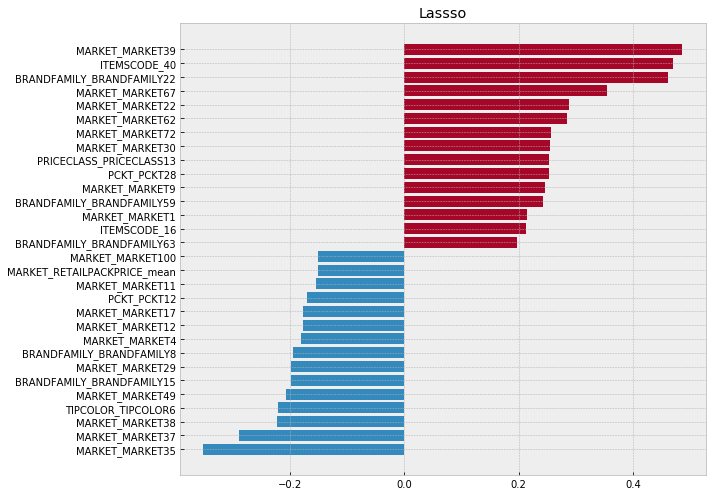

In [22]:
feat_imp = pd.Series(all_fitted_models['lasso']._final_estimator.coef_, index=X_train.columns)
feat_imp.sort_values(inplace=True)
plt.figure(figsize=(10, 7))
plt.barh(feat_imp.index[:15], feat_imp.values[:15])
plt.barh(feat_imp.index[-15:], feat_imp.values[-15:])
plt.title('Lassso')
plt.tight_layout()
plt.show()

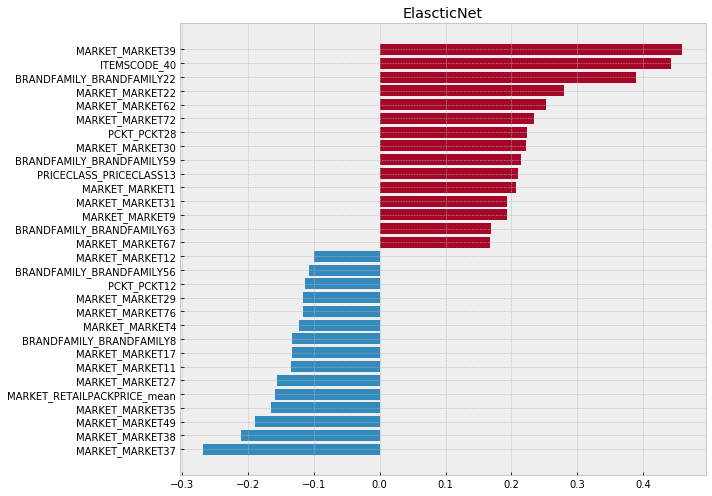

In [23]:
feat_imp = pd.Series(all_fitted_models['elastic_net']._final_estimator.coef_, index=X_train.columns)
feat_imp.sort_values(inplace=True)
plt.figure(figsize=(10, 7))
plt.barh(feat_imp.index[:15], feat_imp.values[:15])
plt.barh(feat_imp.index[-15:], feat_imp.values[-15:])
plt.title('ElascticNet')
plt.tight_layout()
plt.show()

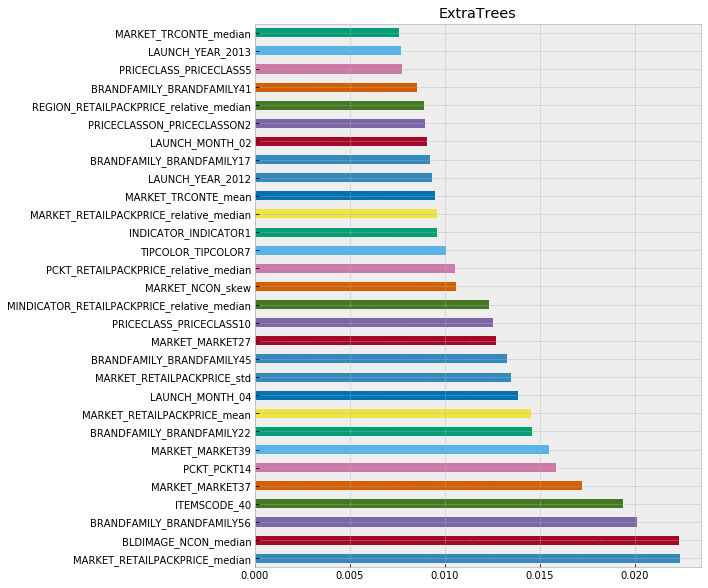

In [24]:
feat_imp = pd.Series(all_fitted_models['extra_tree'].feature_importances_, index=X_train.columns)
feat_imp.nlargest(30).plot(kind='barh', figsize=(8,10))
plt.title('ExtraTrees')
plt.show()

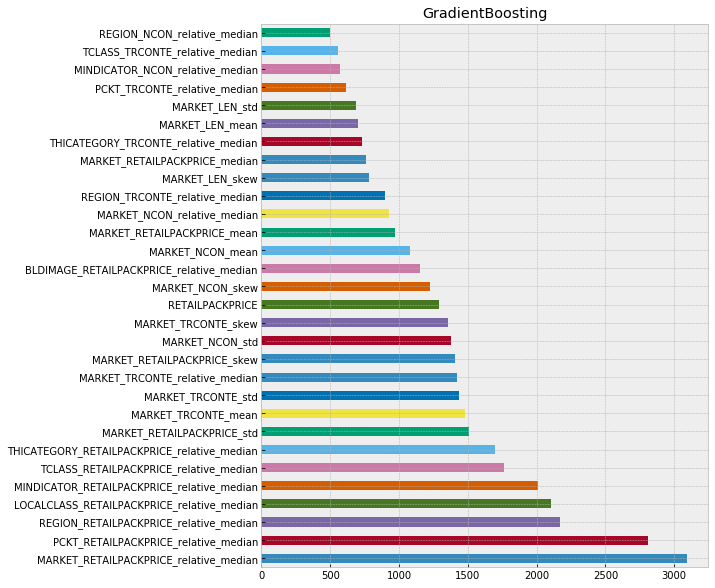

In [26]:
feat_imp = pd.Series(all_fitted_models['gradient_tree_boosting'].feature_importances_, index=X_train.columns)
feat_imp.nlargest(30).plot(kind='barh', figsize=(8,10))
plt.title('GradientBoosting')
plt.show()

From graphs we can see that different features are important for dfferent models. If we take into consideration only GradiendBoosting and ExtraTrees then we can see for both models there is a common tendency that **RETAILPACKPRICE** related features are important. This is is quite intuitive: in reality market share depends on price.

### Parameter optimization

Now lets try to make some parameter optimization. We hope that this will help to overcome overfitting (at least partially).

In [27]:
from hyperopt import hp, tpe
from hyperopt.fmin import fmin

In [50]:
# as a final metric we will use some combined loss
# (1 - auc) * (1 - f_score) * fpr
def final_metric(cv_mean_metrics):
    return (1. - cv_mean_metrics['auc'][0])

In [ ]:
def objective(params):
    
    params = {
        'learning_rate': '{:.5f}'.format(params['learning_rate']),
        'num_leaves': int(params['num_leaves']),
        'colsample_bytree': '{:.3f}'.format(params['colsample_bytree']),
        'min_split_gain': '{:.4f}'.format(params['min_split_gain']),
    }
    
    regressor = lgb.LGBMRegressor(
    boosting_type='gbdt',
    objective='rmse',
    n_estimators=5000,
#     learning_rate=0.03,
    
    max_depth=6,            
#     num_leaves=24,        
    min_child_weight=11,
    min_data_in_leaf=20,      
        
    subsample=0.75,     
    subsample_freq=5,
    bagging_seed=9,
    
#     colsample_bytree=0.45,
    feature_fraction_seed=7,
    
#     min_gain_to_split=0.002,
    reg_alpha=0.0,
    reg_lambda=0.0,
    n_jobs=2,
    **params)

    _, _, v_metrics = cv(regressor, X_train, y_train, n_folds=5, verbose=False)
    return final_metric(v_metrics)

# parameters search space
space = {
    'learning_rate': hp.quniform('learning_rate', 0.01, 0.09, 0.01),
    'num_leaves': hp.quniform('num_leaves', 15, 31, 2),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 0.8),
    'min_split_gain': hp.uniform('min_split_gain', 0.0015, 0.003),
}

best_lgb = fmin(fn=objective,
                space=space,
                algo=tpe.suggest,
                max_evals=50)

In [47]:
best_lgb

{'colsample_bytree': 0.32717076234384207,
 'learning_rate': 0.01,
 'min_split_gain': 0.002725692763292067,
 'num_leaves': 24.0}

In [48]:
regressor = lgb.LGBMRegressor(
    boosting_type='gbdt',
    objective='rmse',
    n_estimators=5000,
    learning_rate=0.01,
    
    max_depth=6,            
    num_leaves=24,        
    min_child_weight=11,
    min_data_in_leaf=20,      
        
    subsample=0.75,     
    subsample_freq=5,
    bagging_seed=9,
    
    colsample_bytree=0.327,
    feature_fraction_seed=7,
    
    min_gain_to_split=0.0027,
    reg_alpha=0.0,
    reg_lambda=0.0,
    n_jobs=2,
    )

l, _, v_metrics = cv(regressor, X_train, y_train, n_folds=5, verbose=False)

In [49]:
print(l)

╒════════════════════╤═══════════════╤══════════════╤═══════════════╤══════════════╕
│ metric_name        │   train: mean │   train: std │   valid: mean │   valid: std │
╞════════════════════╪═══════════════╪══════════════╪═══════════════╪══════════════╡
│ rmse               │         0.068 │        0.001 │         0.252 │        0.007 │
├────────────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│ explained_variance │         0.953 │        0.002 │         0.347 │        0.049 │
├────────────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│ r_2                │         0.953 │        0.002 │         0.344 │        0.051 │
├────────────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│ accuracy           │         0.962 │        0.004 │         0.840 │        0.020 │
├────────────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│ tpr                │         0.863 │        0.015 │         0.4

In [ ]:
def objective(params):
    
    params = {
        'min_samples_split': int(params['min_samples_split']),
        'min_samples_leaf': int(params['min_samples_leaf']),
        'min_weight_fraction_leaf': float('{:.6f}'.format(params['min_weight_fraction_leaf'])),
    }
    
    regressor = ExtraTreesRegressor(
    n_estimators=200,
    max_depth=50,
#     min_samples_split=2, 
#     min_samples_leaf=2,
#     min_weight_fraction_leaf=0.0002,
    max_leaf_nodes=None,
    max_features='auto',
    min_impurity_decrease=0.00,
    n_jobs=2,
    **params)

    _, _, v_metrics = cv(regressor, X_train, y_train, n_folds=5, verbose=False)
    return final_metric(v_metrics)


space = {
    'min_samples_split': hp.quniform('min_samples_split', 2, 5, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 2, 5, 1),
    'min_weight_fraction_leaf': hp.uniform('min_weight_fraction_leaf', 0.0001, 0.00003),
}

best_extratrees = fmin(fn=objective,
                       space=space,
                       algo=tpe.suggest,
                       max_evals=15)

In [ ]:
best_extratrees